# D.2 - Sentiment Analysis

In this notebook, we conduct a sentiment analysis on the titles and descriptions of our goals, using the LabMT word list. We also explore sentiment analysis conducted using VADER, but this is not included in the final paper.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import requests
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

pd.set_option('display.max_colwidth', None)

In [2]:
#importing the notebook, and making sure the nodes and edges are consistent

url = "https://raw.githubusercontent.com/nicosrp/The-Architecture-of-Aspiration-A-Network-Perspective-on-Human-Goals/main/Networks/dayzero_network.pkl"
response = requests.get(url)
G = pickle.loads(response.content)

print(f"Network loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Network loaded: 2890 nodes, 219130 edges


In [3]:
#importing the labMT text file

labmt_path = "../Data/Additional Data/labmt.txt"
labmt_in = pd.read_csv(labmt_path, sep=r"\s+", engine="python", skiprows=2)

#extract the words and the happiness average score
labmt = dict(zip(labmt_in["word"], labmt_in["happiness_average"]))

print(f"LabMT lexicon loaded: {len(labmt)} words")

LabMT lexicon loaded: 10222 words


In [4]:
stop_words = set(stopwords.words("english"))

# Get both title and description
goal_titles = nx.get_node_attributes(G, "title")
goal_descriptions = nx.get_node_attributes(G, "description")

# Combine title and description for full text
goal_full_text = {}
for goal in G.nodes():
    title = goal_titles.get(goal, "")
    description = goal_descriptions.get(goal, "")
    # Combine with space separator
    combined = f"{title} {description}".strip()
    goal_full_text[goal] = combined if combined else None

#process the combined title and description: tokenise and remove stopwords
goal_tokens = {}
for goal, text in goal_full_text.items():
    if text:
        tokens = word_tokenize(text)
        tokens = [t.lower() for t in tokens if t.isalpha()]
        tokens = [t for t in tokens if t not in stop_words]
        goal_tokens[goal] = tokens

#print results to make sure no goals are missing 

print(f"Combined title + description for {len(goal_full_text)} goals")
print(f"Tokenized {len([g for g, t in goal_tokens.items() if t])} goals with content")

Combined title + description for 2890 goals
Tokenized 2890 goals with content


## 1. LabMT Sentiment Analysis

LabMT uses tokenized words (title + description combined) with stopwords removed to calculate average happiness scores. The function highlighted here is utilising previous code from the course, which takes the tokenised descriptions and titles and assigns a combined score for the total collection of tokens.

In [5]:
def calculate_labmt_sentiment(tokens, labmt):
    scores = []
    for token in tokens:
        if token in labmt:
            scores.append(labmt[token])
    
    if not scores:
        return None 
    
    return sum(scores) / len(scores)

In [6]:
#using the function to calculate the score
labmt_results = {}

for goal, tokens in goal_tokens.items():
    scores = [labmt[token] for token in tokens if token in labmt]
    labmt_results[goal] = sum(scores) / len(scores) if scores else None

#assign the sentiment score as an attribute of our network
nx.set_node_attributes(G, labmt_results, name="labmt_sentiment")

#print the number of goals the score is calculated for, to make sure we haven't lost any
print(f"LabMT sentiment calculated for {len([v for v in labmt_results.values() if v is not None])} goals")

LabMT sentiment calculated for 2890 goals


## 2. VADER Sentiment Analysis

VADER analyzes the **full text** (title + description) to capture context, intensifiers, negation, and punctuation effects.

In [7]:
sia = SentimentIntensityAnalyzer()

vader_results = {}
for goal, text in tqdm(goal_full_text.items(), desc="VADER sentiment"):
    if text:
        # VADER uses full text with context (no preprocessing needed)
        scores = sia.polarity_scores(text)
        vader_results[goal] = scores['compound']
    else:
        vader_results[goal] = None

nx.set_node_attributes(G, vader_results, name="vader_sentiment")
print(f"VADER sentiment calculated for {len([v for v in vader_results.values() if v is not None])} goals")

VADER sentiment: 100%|██████████| 2890/2890 [00:00<00:00, 3058.72it/s]

VADER sentiment calculated for 2890 goals


## 3. Summary Statistics

In [8]:
labmt_scores = nx.get_node_attributes(G, "labmt_sentiment")
vader_scores = nx.get_node_attributes(G, "vader_sentiment")

labmt_values = np.array([v for v in labmt_scores.values() if v is not None])
vader_values = np.array([v for v in vader_scores.values() if v is not None])

stats_df = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Std Dev', '25th Percentile', '75th Percentile', 'Min', 'Max'],
    'LabMT': [
        labmt_values.mean(),
        np.median(labmt_values),
        labmt_values.std(),
        np.percentile(labmt_values, 25),
        np.percentile(labmt_values, 75),
        labmt_values.min(),
        labmt_values.max()
    ],
    'VADER': [
        vader_values.mean(),
        np.median(vader_values),
        vader_values.std(),
        np.percentile(vader_values, 25),
        np.percentile(vader_values, 75),
        vader_values.min(),
        vader_values.max()
    ]
})

print(stats_df.to_string(index=False))

         Metric    LabMT     VADER
           Mean 5.935080  0.433461
         Median 5.935733  0.476700
        Std Dev 0.261326  0.472856
25th Percentile 5.762052  0.000000
75th Percentile 6.111349  0.885950
            Min 4.793043 -0.969000
            Max 7.400000  0.996500


In [9]:
# Get goals with both sentiment scores (no None values)
valid_goals = [goal for goal in labmt_scores.keys() 
               if labmt_scores[goal] is not None and vader_scores[goal] is not None]

print("="*80)
print("TOP 10 MOST POSITIVE GOALS - LabMT")
print("="*80)

# Sort by LabMT score (descending)
labmt_sorted = sorted(valid_goals, key=lambda g: labmt_scores[g], reverse=True)
for i, goal in enumerate(labmt_sorted[:10], 1):
    goal_title = G.nodes[goal].get('title', goal)
    print(f"{i:2d}. {goal_title} (LabMT: {labmt_scores[goal]:.3f}, VADER: {vader_scores[goal]:.3f})")

print("\n" + "="*80)
print("TOP 10 MOST NEGATIVE GOALS - LabMT")
print("="*80)

# Sort by LabMT score (ascending)
for i, goal in enumerate(labmt_sorted[-10:][::-1], 1):
    goal_title = G.nodes[goal].get('title', goal)
    print(f"{i:2d}. {goal_title} (LabMT: {labmt_scores[goal]:.3f}, VADER: {vader_scores[goal]:.3f})")

print("\n" + "="*80)
print("TOP 10 MOST POSITIVE GOALS - VADER")
print("="*80)

# Sort by VADER score (descending)
vader_sorted = sorted(valid_goals, key=lambda g: vader_scores[g], reverse=True)
for i, goal in enumerate(vader_sorted[:10], 1):
    goal_title = G.nodes[goal].get('title', goal)
    print(f"{i:2d}. {goal_title} (LabMT: {labmt_scores[goal]:.3f}, VADER: {vader_scores[goal]:.3f})")

print("\n" + "="*80)
print("TOP 10 MOST NEGATIVE GOALS - VADER")
print("="*80)

# Sort by VADER score (ascending)
for i, goal in enumerate(vader_sorted[-10:][::-1], 1):
    goal_title = G.nodes[goal].get('title', goal)
    print(f"{i:2d}. {goal_title} (LabMT: {labmt_scores[goal]:.3f}, VADER: {vader_scores[goal]:.3f})")

TOP 10 MOST POSITIVE GOALS - LabMT
 1. Bake a chocolate cake (LabMT: 7.400, VADER: 0.000)
 2. Decorate a cake (LabMT: 6.809, VADER: 0.649)
 3. Attend the Verona in Love festivities (LabMT: 6.805, VADER: 0.991)
 4. Make a Christmas cake (LabMT: 6.674, VADER: 0.000)
 5. Visit Paradise Valley (LabMT: 6.672, VADER: 0.856)
 6. Visit Haleakalā National Park (LabMT: 6.664, VADER: 0.968)
 7. Take a moonlit walk around Andromeda Gardens (LabMT: 6.664, VADER: 0.914)
 8. Attend the Cherry Blossom Festival in Yeouido’s Cherry Blossom Park in Seoul (LabMT: 6.661, VADER: 0.984)
 9. Visit India during the Holi festival (LabMT: 6.613, VADER: 0.987)
10. Attend the Epcot International Food & Wine Festival (LabMT: 6.610, VADER: 0.972)

TOP 10 MOST NEGATIVE GOALS - LabMT
 1. Visit Gettysburg (LabMT: 4.793, VADER: -0.859)
 2. Visit Topography of Terror (LabMT: 4.895, VADER: -0.961)
 3. Visit the Vietnam Veterans Memorial in Washington, D.C (LabMT: 4.976, VADER: -0.886)
 4. Visit the Shouting Hill (LabMT: 5

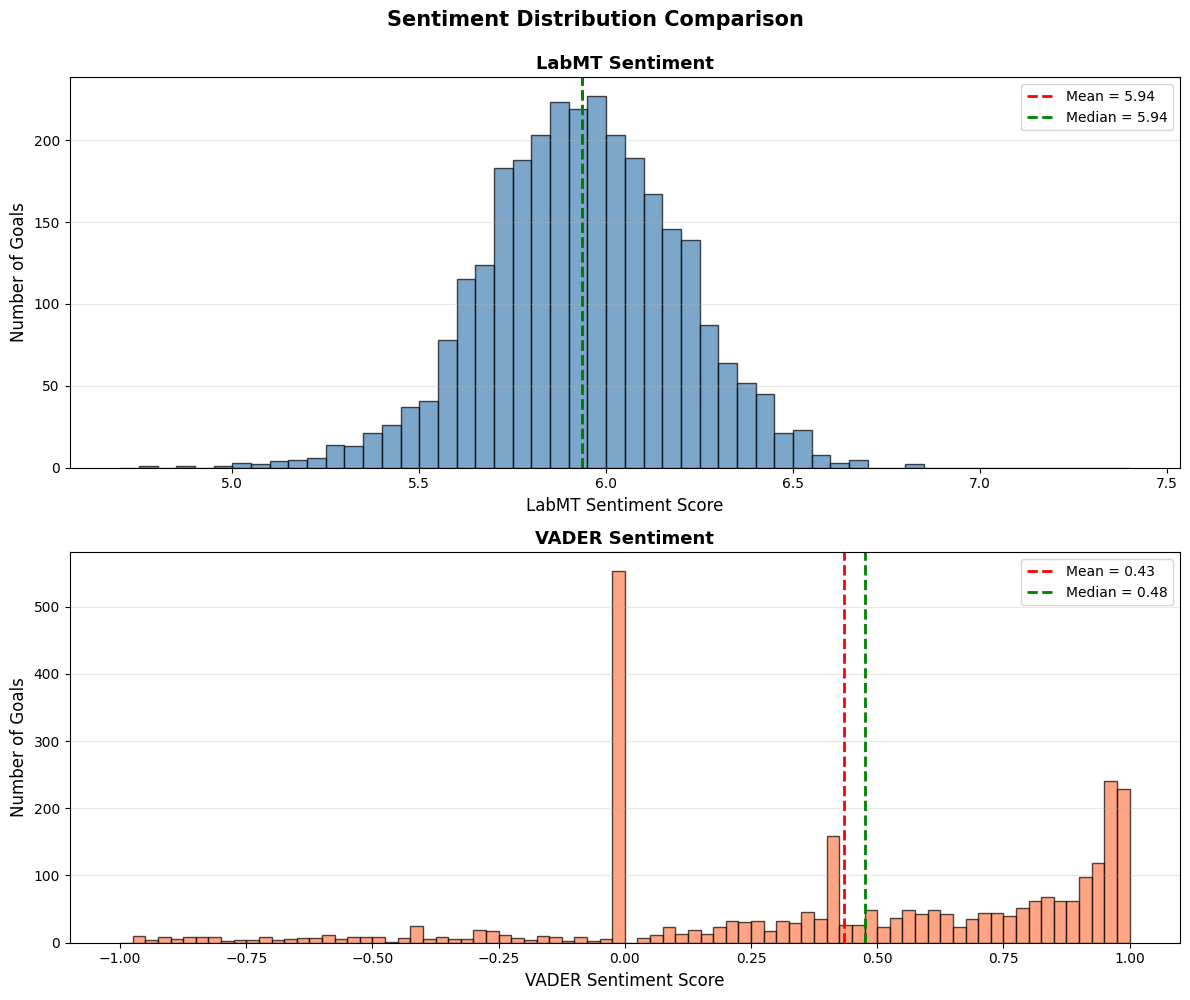

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# LabMT bins aligned to nice numbers
labmt_min = np.floor(labmt_values.min() * 10) / 10
labmt_max = np.ceil(labmt_values.max() * 10) / 10
labmt_range = labmt_max - labmt_min
bins_labmt = np.arange(labmt_min, labmt_max + 0.05, 0.05)
num_bins_labmt = len(bins_labmt) - 1

axes[0].hist(labmt_values, bins=bins_labmt, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(labmt_values.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {labmt_values.mean():.2f}')
axes[0].axvline(np.median(labmt_values), color='green', linestyle='--', linewidth=2, 
                label=f'Median = {np.median(labmt_values):.2f}')
axes[0].set_xlabel('LabMT Sentiment Score', fontsize=12)
axes[0].set_ylabel('Number of Goals', fontsize=12)
axes[0].set_title('LabMT Sentiment', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# VADER bins - calculate bin width to match number of bins proportionally
vader_min = np.floor(vader_values.min() * 20) / 20
vader_max = np.ceil(vader_values.max() * 20) / 20
vader_range = vader_max - vader_min
vader_bin_width = vader_range / num_bins_labmt * (labmt_range / vader_range)
bins_vader = np.arange(vader_min, vader_max + 0.025, 0.025)

axes[1].hist(vader_values, bins=bins_vader, color='coral', alpha=0.7, edgecolor='black')
axes[1].axvline(vader_values.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {vader_values.mean():.2f}')
axes[1].axvline(np.median(vader_values), color='green', linestyle='--', linewidth=2, 
                label=f'Median = {np.median(vader_values):.2f}')
axes[1].set_xlabel('VADER Sentiment Score', fontsize=12)
axes[1].set_ylabel('Number of Goals', fontsize=12)
axes[1].set_title('VADER Sentiment', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('Sentiment Distribution Comparison', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

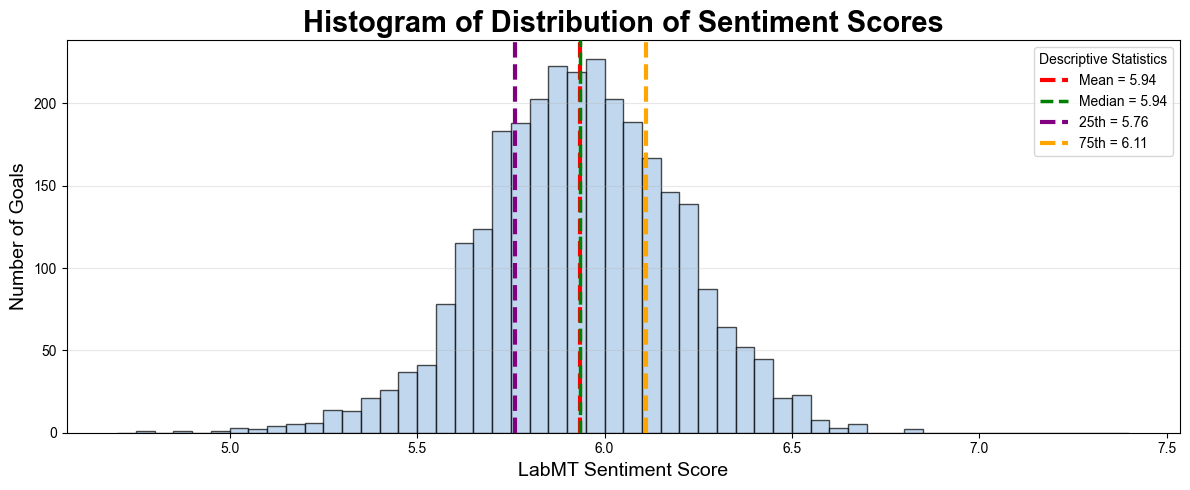

In [11]:
#just getting a histogram for the LabMT findings 

plt.rcParams['font.family'] = 'Arial'

# LabMT bins aligned to nice numbers
labmt_min = np.floor(labmt_values.min() * 10) / 10
labmt_max = np.ceil(labmt_values.max() * 10) / 10
bins_labmt = np.arange(labmt_min, labmt_max + 0.05, 0.05)

# Create a single histogram (styled to match publication plot color)
plt.figure(figsize=(12, 5))

# make bars slightly more transparent so vertical lines are visible
plt.hist(labmt_values, bins=bins_labmt, color='#A7C7E7', alpha=0.7, edgecolor='black', zorder=1)

# Mean and Median lines (zorder higher than bars)
plt.axvline(labmt_values.mean(), color='red', linestyle='--', linewidth=3, label=f'Mean = {labmt_values.mean():.2f}', zorder=3)
plt.axvline(np.median(labmt_values), color='green', linestyle='--', linewidth=2.5, label=f'Median = {np.median(labmt_values):.2f}', zorder=3)
plt.axvline(np.percentile(labmt_values, 25), color='purple', linestyle='--', linewidth=3, label=f"25th = {np.percentile(labmt_values, 25):.2f}", zorder=3)
plt.axvline(np.percentile(labmt_values, 75), color='orange', linestyle='--', linewidth=3, label=f"75th = {np.percentile(labmt_values, 75):.2f}", zorder=3)

# Labels and title (increased sizes as requested)
plt.xlabel('LabMT Sentiment Score', fontsize=14)
plt.ylabel('Number of Goals', fontsize=14)
plt.title('Histogram of Distribution of Sentiment Scores', fontsize=21, fontweight='bold')

plt.legend(title="Descriptive Statistics")
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

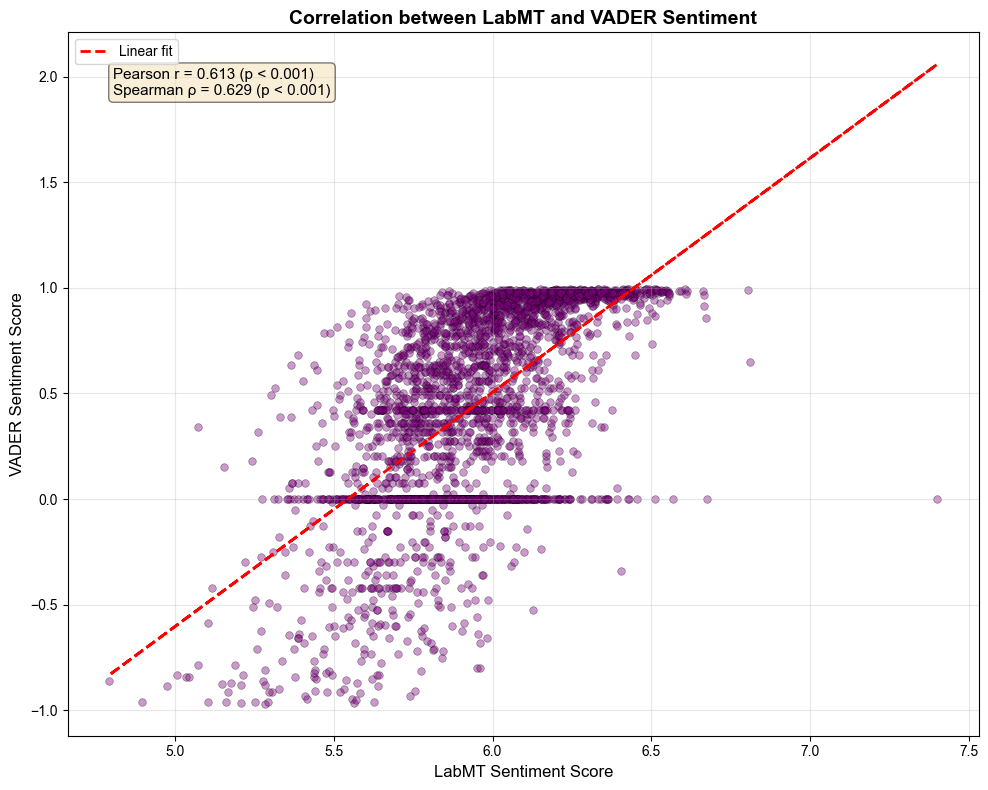

Pearson correlation: r = 0.6129, p-value = 9.6748e-298
Spearman correlation: ρ = 0.6288, p-value = 6.4084e-318


In [12]:
from scipy.stats import pearsonr, spearmanr

# Prepare arrays for correlation (only valid goals)
valid_goals = [goal for goal in labmt_scores.keys() 
               if labmt_scores[goal] is not None and vader_scores[goal] is not None]

labmt_array = np.array([labmt_scores[g] for g in valid_goals])
vader_array = np.array([vader_scores[g] for g in valid_goals])

pearson_r, pearson_p = pearsonr(labmt_array, vader_array)
spearman_r, spearman_p = spearmanr(labmt_array, vader_array)

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(labmt_array, vader_array, alpha=0.4, s=30, color='purple', edgecolor='black', linewidth=0.5)

z = np.polyfit(labmt_array, vader_array, 1)
p = np.poly1d(z)
ax.plot(labmt_array, p(labmt_array), "r--", linewidth=2, label=f'Linear fit')

ax.set_xlabel('LabMT Sentiment Score', fontsize=12)
ax.set_ylabel('VADER Sentiment Score', fontsize=12)
ax.set_title('Correlation between LabMT and VADER Sentiment', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

textstr = f'Pearson r = {pearson_r:.3f} (p < 0.001)\nSpearman ρ = {spearman_r:.3f} (p < 0.001)'
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.legend()
plt.tight_layout()
plt.show()

print(f"Pearson correlation: r = {pearson_r:.4f}, p-value = {pearson_p:.4e}")
print(f"Spearman correlation: ρ = {spearman_r:.4f}, p-value = {spearman_p:.4e}")

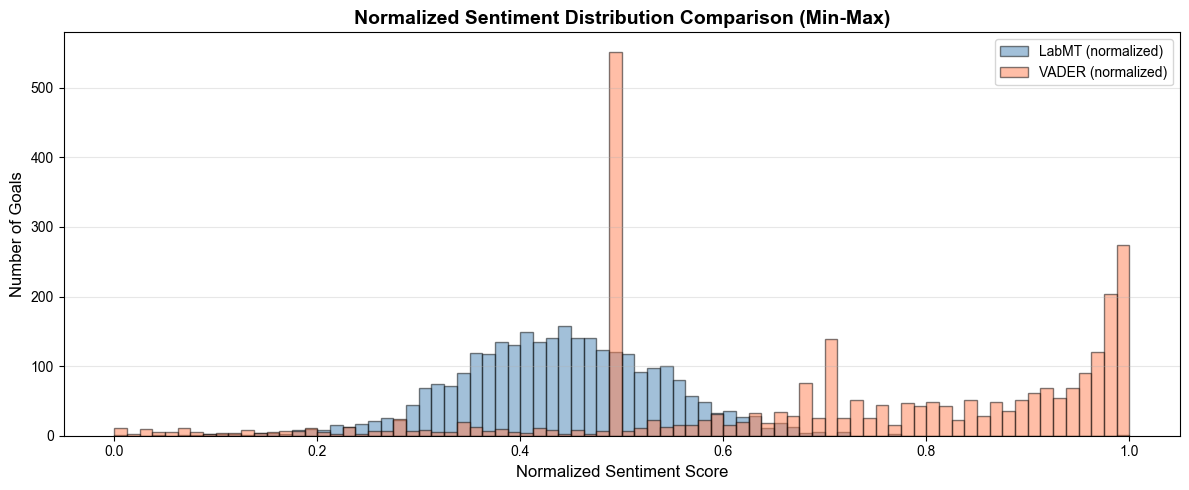

LabMT range: 4.793 to 7.400
VADER range: -0.969 to 0.997


In [13]:
# Min-max normalization based on observed data
labmt_min, labmt_max = labmt_values.min(), labmt_values.max()
vader_min, vader_max = vader_values.min(), vader_values.max()

labmt_normalized = (labmt_values - labmt_min) / (labmt_max - labmt_min)
vader_normalized = (vader_values - vader_min) / (vader_max - vader_min)

fig, ax = plt.subplots(figsize=(12, 5))

bins_norm = np.arange(0, 1.0125, 0.0125)

ax.hist(labmt_normalized, bins=bins_norm, color='steelblue', alpha=0.5, 
        edgecolor='black', label='LabMT (normalized)')
ax.hist(vader_normalized, bins=bins_norm, color='coral', alpha=0.5, 
        edgecolor='black', label='VADER (normalized)')

ax.set_xlabel('Normalized Sentiment Score', fontsize=12)
ax.set_ylabel('Number of Goals', fontsize=12)
ax.set_title('Normalized Sentiment Distribution Comparison (Min-Max)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"LabMT range: {labmt_min:.3f} to {labmt_max:.3f}")
print(f"VADER range: {vader_min:.3f} to {vader_max:.3f}")

In [14]:
# Calculate normalized scores and differences using min-max normalization
valid_goals = [goal for goal in labmt_scores.keys() 
               if labmt_scores[goal] is not None and vader_scores[goal] is not None]

labmt_min, labmt_max = labmt_values.min(), labmt_values.max()
vader_min, vader_max = vader_values.min(), vader_values.max()

labmt_norm = {g: (labmt_scores[g] - labmt_min) / (labmt_max - labmt_min) for g in valid_goals}
vader_norm = {g: (vader_scores[g] - vader_min) / (vader_max - vader_min) for g in valid_goals}
diff_scores = {g: abs(labmt_norm[g] - vader_norm[g]) for g in valid_goals}

# Sort by difference (descending)
diff_sorted = sorted(valid_goals, key=lambda g: diff_scores[g], reverse=True)

print("Top 10 goals with highest difference in normalized sentiment scores:\n")
for goal in diff_sorted[:10]:
    goal_title = G.nodes[goal].get('title', goal)
    goal_desc = G.nodes[goal].get('description', 'No description')
    print(f"{goal_title}")
    print(f"  Description: {goal_desc}")
    print(f"  LabMT: {labmt_scores[goal]:.3f} (norm: {labmt_norm[goal]:.3f})")
    print(f"  VADER: {vader_scores[goal]:.3f} (norm: {vader_norm[goal]:.3f})")
    print(f"  Difference: {diff_scores[goal]:.3f}\n")

Top 10 goals with highest difference in normalized sentiment scores:

Visit the United States Holocaust Memorial Museum
  Description: The United States Holocaust Memorial Museum (USHMM) is the United States' official memorial to the Holocaust. Adjacent to the National Mall in Washington, D.C. , the USHMM provides for the documentation, study, and interpretation of Holocaust history. It is dedicated to helping leaders and citizens of the world confront hatred, prevent genocide, promote human dignity, and strengthen democracy.
  LabMT: 5.601 (norm: 0.310)
  VADER: 0.925 (norm: 0.963)
  Difference: 0.653

Visit the United Arab Emirates
  Description: The United Arab Emirates (UAE) is a federation situated in the southeast of the Arabian Peninsula in Southwest Asia on the Persian Gulf, bordering Oman and Saudi Arabia and sharing sea borders with Iraq, Kuwait, Bahrain, Qatar and Iran. The UAE consists of seven states, termed emirates, (because they are ruled by Emirs) which are Abu Dhabi, 